# Label Detection

## Axes Detection
This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

In [1]:
!pip install opencv-python
!pip install XlsxWriter
!pip install pytesseract
!sudo apt install tesseract-ocr
!pip install -U pillow


     |████████████████████████████████| 149 kB 25.5 MB/s 
     |████████████████████████████████| 4.3 MB 27.5 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (25.9 MB

In [2]:
import cv2, imutils, re, xlsxwriter, json
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pathlib import Path
from matplotlib import rcParams
from pytesseract import Output
import PIL

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/chart'
%cd /content/gdrive/My Drive/Colab Notebooks/chart 

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/chart


In [4]:
# Directory of images to run the code on
img_dir = 'test'

# Directory to save the output images
save_dir = 'out'

In [5]:
with open('data/urldata.json') as handler:
    urldata = json.load(handler)

### Function to detect x-axis and y-axis for a plot

In [6]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [7]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the max-consecutive-ones for eah column in the bw image, and...
    # pick the "first" index that fall in [max - threshold, max + threshold]
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            break
            
        start_idx += 1
           
    yaxis = (maxindex, 0, maxindex, height)
    
    if debug:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(image)

        ax[1].plot(maxConsecutiveOnes, color = 'k')
        ax[1].axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        ax[1].axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        ax[1].vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    # Get the max-consecutive-ones for eah row in the bw image, and...
    # pick the "last" index that fall in [max - threshold, max + threshold]
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            
        start_idx += 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis

### Here we try to get text from the image using pytesseract

In [8]:
def getTextFromImage(filepath, bw=False, debug=False):
    image_text = []
    
    image = cv2.imread(filepath)
    height, width, _ = image.shape
        
    if bw:
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # define range of black color in HSV
        lower_val = np.array([0, 0, 0])
        upper_val = np.array([179, 255, 179])

        # Threshold the HSV image to get only black colors
        mask = cv2.inRange(hsv, lower_val, upper_val)

        # Bitwise-AND mask and original image
        res = cv2.bitwise_and(image, image, mask = mask)

        # invert the mask to get black letters on white background
        image = cv2.bitwise_not(mask)
            
    d = pytesseract.image_to_data(image, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
     
    if bw:  
        image = cv2.imread(filepath)
        image_text = list(set(image_text))
        white_bg = 255 * np.ones_like(image)
        
        for text, (textx, texty, w, h) in image_text:
            roi = image[texty:texty + h, textx:textx + w]
            white_bg[texty:texty + h, textx:textx + w] = roi
            
        image_text = []
        d = pytesseract.image_to_data(white_bg, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
        n_boxes = len(d['text'])

        # Pick only the positive confidence boxes
        for i in range(n_boxes):

            if int(d['conf'][i]) >= 0:

                text = d['text'][i].strip()
                (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                image_text.append((d['text'][i], (x, y, w, h)))
        
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

### This function is to calculate the probable x-labels, y-labels and legend text

Here is the logic for the same

1. X-labels

    a. Check only the text boxes which are below the x-axis(, and to the right of y-axis).
    
    b. Run a line sweep from x-axis to the bottom of the image, and check when the sweeping line intersects with the maximum            number of text boxes.
    
    c. This maximum intersection gives all the x-labels



2. Y-labels:

    a. Check only the text boxes which are to the left of y-axis(, and to the top of x-axis).
    
    b. Run a line sweep from left end of the image to the y-axis position, and check when the sweeping line intersects with the        maximum number of text boxes.
    
    c. This maximum intersection gives all the y-labels


    
3. Legend text:
    
    a. Check only the text boxes in the remaining region (right to the y-axis and top of x-axis)
    
    b. Only Consider text boxes which have non-numeric text
    
    c. Run the sweeping line algorithm twice now - Once in the x-direction and the second time in the y-direction
    
    d. The maximum intersections gives all the legend texts.

In [9]:
def getProbableLabels(image, image_text, xaxis, yaxis):
    y_labels = []
    x_labels = []
    legends = []
    
    height, width, channels = image.shape
    
    for text, (textx, texty, w, h) in image_text:
        text = text.strip()
                    
        (x1, y1, x2, y2) = xaxis
        (x11, y11, x22, y22) = yaxis
            
        # To the right of y-axis and bottom of x-axis
        if (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == 1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            x_labels.append((text, (textx, texty, w, h)))
            
        # Top of x-axis and to the right of y-axis
        elif (np.sign((x2 - x1) * (texty - y1) - (y2 - y1) * (textx - x1)) == -1 and
            np.sign((x22 - x11) * (texty - y11) - (y22 - y11) * (textx - x11)) == -1):
            
            # Consider non-numeric only for legends
            if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                legends.append((text, (textx, texty, w, h)))
                
    # Get the x-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(y1, height):
        count = 0
        current = []
        for index, (text, rect) in enumerate(x_labels):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(x_labels[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
    
    # Sort bounding rects by x coordinate
    def getYFromRect(item):
        return item[1]

    maxList.sort(key = getYFromRect)
    
    x_labels = []
    for text, (textx, texty, w, h) in maxList:
        x_labels.append(text)
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 0), 2)
    
    # Get possible legend text
    # For this, we need to search both top to
    # bottom and also from left to right.
    maxIntersection = 0
    maxList = []
    for i in range(y1):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectY(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
            
    for i in range(x11, width):
        count = 0
        current = []
        for index, (text, rect) in enumerate(legends):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(legends[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
        
    legends = []
    legendBoxes = []
    for text, (textx, texty, w, h) in maxList:
        legends.append(text)
        legendBoxes.append((textx, texty, w, h))
        #cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    legendBoxes = mergeRects(legendBoxes)
    
    for (textx, texty, w, h) in legendBoxes:
        cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
    
    print("number of clusters : ", len(legendBoxes))
        
    return image, x_labels, _, legends

In [10]:
def lineIntersectsRectX(candx, rect):
    (x, y, w, h) = rect
    
    if x <= candx <= x + w:
        return True
    else:
        return False
    
def lineIntersectsRectY(candy, rect):
    (x, y, w, h) = rect
    
    if y <= candy <= y + h:
        return True
    else:
        return False

In [11]:
def getTextFromImageArray(image, mode):
    image_text = []
    
    if mode == 'y-text':
        image = cv2.transpose(image)
        image = cv2.flip(image, flipCode = 1)
        config = "-l eng --oem 1 --psm 11"
    elif mode == 'y-labels':
        config = "-l eng --oem 1 --psm 6 -c tessedit_char_whitelist=.0123456789"
    
    d = pytesseract.image_to_data(image, config = config, output_type = Output.DICT)
    
    n_boxes = len(d['text'])

    # Pick only the positive confidence boxes
    for i in range(n_boxes):
            
        if int(d['conf'][i]) >= 0:
                
            text = d['text'][i].strip()
            
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image_text.append((d['text'][i], (x, y, w, h)))
            
    # Remove all the duplicates in (text, box) pairs
    return list(set(image_text))

In [12]:
def maskImageForwardPass(filepath, start_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        start_idx = 1
        while start_idx <= width:
            if sum(gray[:, start_idx] < 200) != 0:
                break
            else:
                start_idx += 1
                
        end_idx = start_idx
        while end_idx <= width:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx += 1
                
        gray[:, 1:start_idx] = 255
        gray[:, end_idx:width] = 255
        
        return gray, start_idx, end_idx

In [13]:
def maskImageBackwardPass(filepath, end_idx):
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        height, width, channels = image.shape

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        while end_idx > 0:
            if sum(gray[:, end_idx] < 200) == 0:
                break
            else:
                end_idx -= 1
        
        gray[:, end_idx:width] = 255
        
        return gray

## Writing to Excel workbook

In [14]:
def addToExcel(dataname, data, row):
    col = 0

    worksheet.write(row, col, dataname)
    for content in data:
        col += 1
        worksheet.write(row, col, content)

In [15]:
def nearbyRectangle(current, candidate, threshold):
    (currx, curry, currw, currh) = current
    (candx, candy, candw, candh) = candidate
    
    currxmin = currx
    currymin = curry
    currxmax = currx + currw
    currymax = curry + currh
    
    candxmin = candx
    candymin = candy
    candxmax = candx + candw
    candymax = candy + candh
    
    # If candidate is on top, and is close
    if candymax <= currymin and candymax + threshold >= currymin:
        return True
    
    # If candidate is on bottom and is close
    if candymin >= currymax and currymax + threshold >= candymin:
        return True
    
    # If intersecting at the top, merge it
    if candymax >= currymin and candymin <= currymin:
        return True
    
    # If intersecting at the bottom, merge it
    if currymax >= candymin and currymin <= candymin:
        return True
    
    # If intersecting on the sides or is inside, merge it
    if (candymin >= currymin and
        candymin <= currymax and
        candymax >= currymin and
        candymax <= currymax):
        return True
    
    return False

In [16]:
def mergeRects(contours):
    rects = []
    rectsUsed = []

    # Just initialize bounding rects and set all bools to false
    for cnt in contours:
        rects.append(cnt)
        #rects.append(cv2.boundingRect(cnt))
        rectsUsed.append(False)

    # Sort bounding rects by x coordinate
    def getXFromRect(item):
        return item[0]

    rects.sort(key = getXFromRect)

    # Array of accepted rects
    acceptedRects = []

    # Merge threshold for x coordinate distance
    xThr = 5
    yThr = 5

    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if (rectsUsed[supIdx] == False):

            # Initialize current rect
            currxMin = supVal[0]
            currxMax = supVal[0] + supVal[2]
            curryMin = supVal[1]
            curryMax = supVal[1] + supVal[3]

            # This bounding rect is used
            rectsUsed[supIdx] = True

            # Iterate all initial bounding rects
            # starting from the next
            for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

                # Initialize merge candidate
                candxMin = subVal[0]
                candxMax = subVal[0] + subVal[2]
                candyMin = subVal[1]
                candyMax = subVal[1] + subVal[3]

                # Check if x distance between current rect
                # and merge candidate is small enough
                if (candxMin <= currxMax + xThr):

                    if not nearbyRectangle((candxMin, candyMin, candxMax - candxMin, candyMax - candyMin),
                                           (currxMin, curryMin, currxMax - currxMin, curryMax - curryMin), yThr):
                        break

                    # Reset coordinates of current rect
                    currxMax = candxMax
                    curryMin = min(curryMin, candyMin)
                    curryMax = max(curryMax, candyMax)

                    # Merge candidate (bounding rect) is used
                    rectsUsed[subIdx] = True
                else:
                    break

            # No more merge candidates possible, accept current rect
            acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])

    #for rect in acceptedRects:
    #    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (121, 11, 189), 2)
    
    return acceptedRects

In [17]:
def getProbableYLabels(image, contours, xaxis, yaxis):
    y_labels = []
    
    height, width, channels = image.shape
    
    (x1, y1, x2, y2) = xaxis
    (x11, y11, x22, y22) = yaxis
    
    # Get the y-labels by finding the maximum
    # intersections with the sweeping line
    maxIntersection = 0
    maxList = []
    for i in range(x11):
        count = 0
        current = []
        for index, rect in enumerate(contours):
            if lineIntersectsRectX(i, rect):
                count += 1
                current.append(contours[index])
                            
        if count > maxIntersection:
            maxIntersection = count
            maxList = current
                    
    return image, maxList

number of contours:  0


AttributeError: ignored

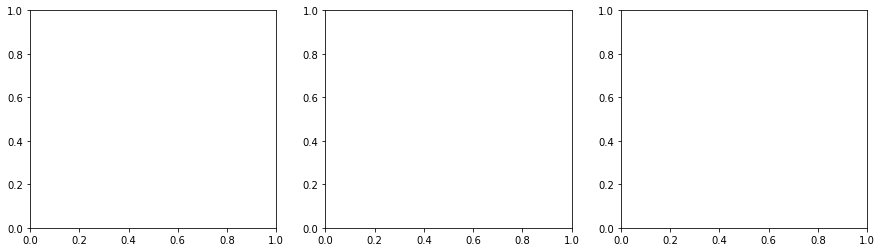

In [18]:
workbook = xlsxwriter.Workbook('FigureData.xlsx')

for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg') or path.name.endswith('.jpeg'):

        filepath = img_dir + "/" + path.name
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        height, width, channels = image.shape
        xaxis, yaxis = detectAxes(filepath)
        y_text, y_labels = [], []
        
        for (x1, y1, x2, y2) in [xaxis]:
            xaxis = (x1, y1, x2, y2)

        for (x1, y1, x2, y2) in [yaxis]:
            yaxis = (x1, y1, x2, y2)
        
        rcParams['figure.figsize'] = 15, 4
        fig, ax = plt.subplots(1, 3)
        
        # Make a backward pass to skip the ticks
        gray = maskImageBackwardPass(filepath, yaxis[0])
        
        # Processing the image so that the contours are drawn to labels and text
        ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
        thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
        thresh = cv2.dilate(thresh, rect_kernel, iterations = 1)
        
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        rects = [cv2.boundingRect(contour) for contour in contours]
        print("number of contours: ", len(contours))
        
        image_text = getTextFromImage(filepath, bw=True)
        image, y_labels = getProbableYLabels(image, rects, xaxis, yaxis)
        white_bg = 255 * np.ones_like(gray.copy())
        
        for (textx, texty, w, h) in y_labels:
            roi = gray[texty:texty + h, textx:textx + w]
            white_bg[texty:texty + h, textx:textx + w] = roi
        
        # Get y-labels
        y_labels_list = getTextFromImageArray(white_bg, 'y-labels')
        ax[0].imshow(white_bg, aspect = 'auto')
        
        # Sort bounding rects by y coordinate
        def getYFromRect(item):
            return item[1][1]

        # Whiten y-labels and get y-text
        y_labels_list.sort(key = getYFromRect)
        y_labels = []
        for text, (textx, texty, w, h) in y_labels_list:
            roi = 255 * np.ones_like(gray[texty:texty + h, textx:textx + w])
            gray[texty:texty + h, textx:textx + w] = roi
            y_labels.append(text)
        
        y_text_list = getTextFromImageArray(gray, 'y-text')
        
        # Sort bounding rects by x coordinate
        def getXFromRect(item):
            return item[1][0]
        
        y_text_list.sort(key = getXFromRect)        
        for text, (textx, texty, w, h) in y_text_list:
            y_text.append(text)
        
        # Get the remaining: x-labels and legends
        image_text = getTextFromImage(filepath, bw=True)
        image, x_labels, _, legends = getProbableLabels(image, image_text, xaxis, yaxis)
        
        # Write to Excel
        worksheet = workbook.add_worksheet()
        addToExcel("x-labels", x_labels, 1)
        addToExcel("y-text", y_text, 2)
        addToExcel("y-labels", y_labels, 3)
        addToExcel("legends", legends, 4)
        
        # Print the output here!
        print("file name    :  ", path.name)
        print("x-labels     :  ", x_labels)
        print("y-text       :  ", y_text)
        print("y-labels     :  ", y_labels)
        print("legends      :  ", legends, end = "\n\n")
        
        for (x1, y1, x2, y2) in [xaxis]:
            cv2.line(image, (x1, y1), (x2, y2),  (0, 0, 255), 2)
            
        for (x1, y1, x2, y2) in [yaxis]:
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
        for text, (textx, texty, w, h) in y_labels_list:
            cv2.rectangle(image, (textx, texty), (textx + w, texty + h), (255, 0, 255), 2)
        
        ax[1].imshow(gray, aspect = 'auto')
        ax[2].imshow(image, aspect = 'auto')
        
        # Insert the image
        worksheet.insert_image('B8', filepath)
        
# Close the excel workbook!
workbook.close()